In [1]:
#importing libraries

from decay_model.utility_functions import data_augmentation_functions_new
from tqdm.notebook import tqdm
from probeinterface.plotting import plot_probe
from decay_model.utility_functions import clustering_plotting_functions

import numpy as np
import matplotlib.pyplot as plt
import h5py
import wandb
import matplotlib as mpl

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeextractors as see
import spikeinterface.comparison as sc
import MEArec as mr

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from collections import defaultdict
from spikeinterface.sortingcomponents.peak_localization import localize_peaks


# Loading Data

In [2]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
save_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/peak localize files/'

#
width = 40 # The distance from the channel with the largest amplitude spike for which channels are included in the constructed data (microns).
spike_jitter = 5 # The number of frames used to align the extracted waveforms. We search within +-5 frames of the ground truth spike time to find the true peak.
amp_jitter = 0 # The amplitude jitter hyperparameter (described in the manuscript)
save = True # Save the dataset to the save_directory if True

In [3]:
file_name = recording_directory + recording_name
print(file_name)
recgen = mr.load_recordings(file_name)
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]
#channel_positions = recgen.channel_positions

recording, sorting = se.read_mearec(file_name)

/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5


# Preprocessing

BandpassFilterRecording: 100 channels - 1 segments - 32.0kHz - 60.000s
CommonReferenceRecording: 100 channels - 1 segments - 32.0kHz - 60.000s
Use cache_folder=/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmp3tvjydq3/FRYID2YO
write_binary_recording with n_jobs 1  chunk_size None
BinaryRecordingExtractor: 100 channels - 1 segments - 32.0kHz - 60.000s
  file_paths: ['/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmp3tvjydq3/FRYID2YO/traces_cached_seg0.raw']


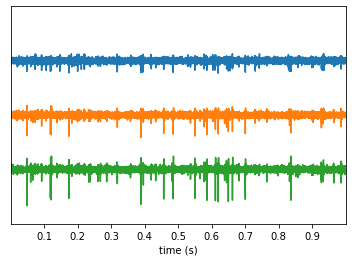

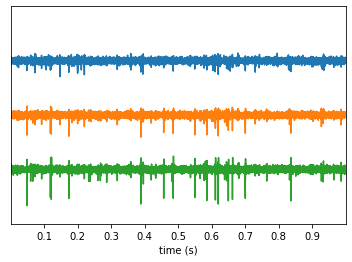

In [4]:
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)
# Looking at the data after bandpass filter
w = sw.plot_timeseries(recording_f, channel_ids=['1', '2', '3'])

#recording_notch = st.notch_filter(recording, freq=2000, q=30)
#print(recording_notch)
#w_notch = sw.plot_timeseries(recording_notch, channel_ids=['1', '2', '3'])

recording_cmr = st.common_reference(recording_f, reference='global', operator='median')
print(recording_cmr)
# We can also apply other preprocessing steps to further increase the quality of the recording. 
# Common Median Reference (CMR)
w_cmr = sw.plot_timeseries(recording_cmr, channel_ids=['1', '2', '3'])

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

# Waveforms and Peaks

In [5]:
waveforms = si.WaveformExtractor.create(recording_preprocessed, sorting, 'waveforms new', remove_if_exists=True)
waveforms.set_params(ms_before=1, ms_after=1.5, max_spikes_per_unit=None)
waveforms.run_extract_waveforms(n_jobs=-1, chunk_size=30000, progress_bar=True)
print(waveforms)

extract waveforms memmap: 100%|█████████████████| 64/64 [00:41<00:00,  1.53it/s]


WaveformExtractor: 100 channels - 50 units - 1 segments
  before:32 after:48 n_per_units:None


In [6]:
job_kwargs = dict(chunk_duration='1s', n_jobs=-1, progress_bar=True)

peaks = st.get_peaks_from_templates(
    waveforms,
    peak_sign="both",
    radius_um=40,
    **job_kwargs,
)
    


compute waveform features: 100%|███████████████| 60/60 [00:00<00:00, 834.38it/s]


In [7]:
job_kwargs = dict(chunk_duration='1s', n_jobs=1, progress_bar=True)
method_kwargs = {'local_radius_um': 40, 'max_distance_um': 100, 'optimizer': 'least_square'}
method = 'center_of_mass'
ms_before=1 
ms_after=1.5

peak_locations_com = localize_peaks(recording_preprocessed, peaks, method= method, #'center_of_mass', 'monopolar_triangulation',
                                ms_before=ms_before, ms_after=ms_after,method_kwargs=method_kwargs,
                                **job_kwargs)

wandb.init(project="dissertation_new", entity="zelihasag", config = {
    "method": method,
    "ms_before":ms_before, 
    "ms_after":ms_after,
    **method_kwargs
})


localize peaks: 100%|###########################| 60/60 [00:00<00:00, 69.86it/s]
wandb: Currently logged in as: zelihasag. Use `wandb login --relogin` to force relogin


In [8]:
recgen = mr.load_recordings(file_name)
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]


In [9]:
s= sorting.get_all_spike_trains()[0]

In [10]:
all_errors = defaultdict(list)
all_locations = defaultdict(list)
neuron_pos_all = []


for i in range(len(peak_locations_com)): #len(peak_locations)):
    
    unit_id = int(s[1][i][1:])
    neuron_pos = soma_positions[unit_id]
    neuron_pos_all.append(neuron_pos)
    est_pos = peak_locations_com[i]
    error_dist = np.linalg.norm(np.array([est_pos['x'], est_pos['y']]) - neuron_pos[1:3])
    all_errors[unit_id].append(error_dist)
    #all_locations[unit_id].append([est_pos['x']+channel_positions[channel_ind[i]][1], est_pos['y']+channel_positions[channel_ind[i]][2]])
    all_locations[unit_id].append([est_pos['x'], est_pos['y']])
    

In [11]:
spike_number = 0
neuron_std = 0 
neuron_errors_all = []
neuron_stds_all = []
spike_errors_all = []


for neuron in range(50):
    if(len(all_errors[neuron]) != 0):
        neuron_error = np.mean(all_errors[neuron])
        neuron_std = np.std(all_errors[neuron])
        spike_number += len(all_errors[neuron])
        spike_errors_all = spike_errors_all + all_errors[neuron]
        neuron_errors_all.append(neuron_error)
        neuron_stds_all.append(neuron_std)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all)))

wandb.log({
        "Total Spike 2D Error_COM": str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)),
        "Total Neuron 2D Error_COM": str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all))
})

Total Spike 2D Error: 18.995194310551447 +- 11.743672082441142
Total Neuron 2D Error: 19.930789417639442 +- 3.7599105608341348


In [12]:
channel_positions_new = np.asarray(recording.get_channel_locations())

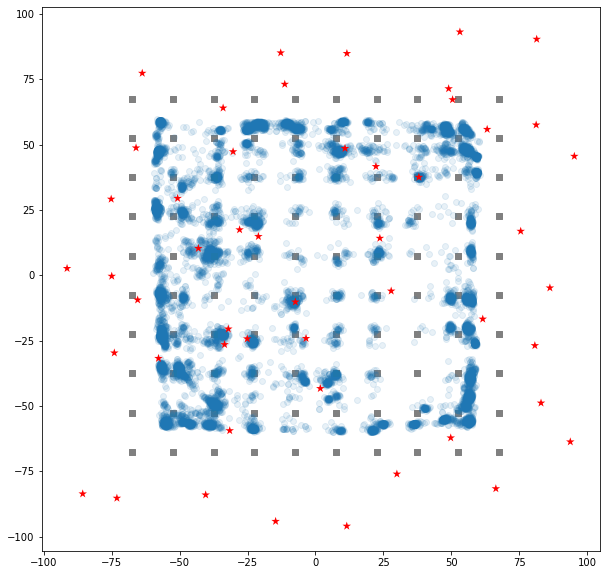

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(channel_positions_new[:,0], channel_positions_new[:,1], marker='s', color='grey')
plt.scatter(peak_locations_com['x'], peak_locations_com['y'], alpha=.1)
#plt.scatter(loc_y, loc_z, alpha=.1)
plt.scatter(np.array(soma_positions)[:,1], np.array(soma_positions)[:,2],  s=80, marker='*', c="red", lw=0, edgecolor='none')

wandb.log({
    "Estimated locations COM": wandb.Image(plt)
})



In [14]:
def plot2DLocations(channel_positions, neurons, locs, neuron_locs, ax=None, dims=[0,1], dims_soma=[1,2], figsize=(8,8), alpha=.3, xlims=None, ylims=None, epochs=0, annotate=True):
    import colorsys
    
    N = 50
    HSV_tuples = [(x*1.0/N, .75, .75) for x in range(N)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    np.random.seed(0)
    _color = 1.0 * np.random.permutation(len(set(neurons))) / len(set(neurons))
    hs_c = plt.cm.hsv(_color[neurons])
    RGB_tuples = hs_c
    if(ax == None):
        f, ax = plt.subplots(figsize=figsize)   
    if(ylims is not None):
        ax.set_ylim((ylims[0], ylims[1]))
    if(xlims is not None):
        ax.set_xlim((xlims[0], xlims[1]))
    ax.scatter(channel_positions[:,dims[0]], channel_positions[:,dims[1]], alpha=.3,  c="grey", marker="s", lw=0)

    for neuron in neurons:
        if(len(locs[neuron]) != 0):
            ax.scatter(np.asarray(locs[neuron])[:,dims[0]], np.asarray(locs[neuron])[:,dims[1]], c=RGB_tuples[neuron], alpha=alpha, s=8, rasterized=False, lw=0, edgecolor='none')
            ax.scatter(neuron_locs[neuron][dims_soma[0]], neuron_locs[neuron][dims_soma[1]], s=80, marker='*', c='black', lw=0, edgecolor='none');
        if(annotate):  
            text = ax.annotate(neuron, (neuron_locs[neuron][dims_soma[0]] + 2, neuron_locs[neuron][dims_soma[1]] + 2))
            text.set_fontsize(10)
#         text = ax.annotate("Epochs: " + str(epochs), (-33, 120))
#         text.set_fontsize(10)
    return ax

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

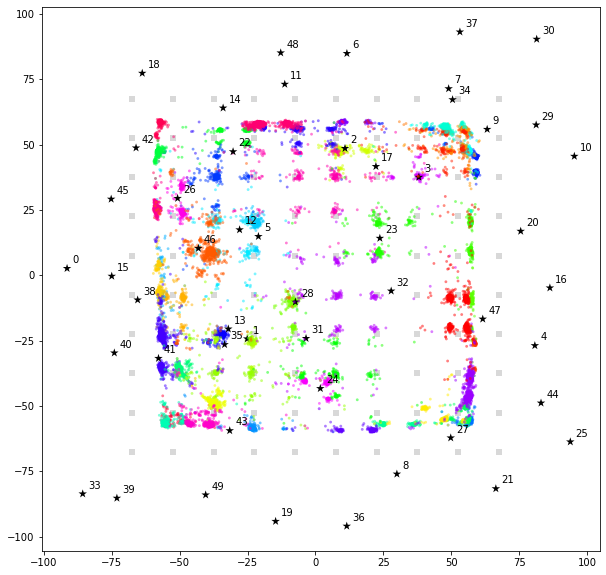

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot2DLocations(channel_positions_new, range(50), all_locations, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);

wandb.log({
    "Estimated locations COM colorful": wandb.Image(plt)
})


In [16]:
(st.get_channel_distances(recording)<40).sum(1)

array([ 8, 11, 13, 13, 13, 13, 13, 13, 11,  8, 11, 15, 18, 18, 18, 18, 18,
       18, 15, 11, 13, 18, 21, 21, 21, 21, 21, 21, 18, 13, 13, 18, 21, 21,
       21, 21, 21, 21, 18, 13, 13, 18, 21, 21, 21, 21, 21, 21, 18, 13, 13,
       18, 21, 21, 21, 21, 21, 21, 18, 13, 13, 18, 21, 21, 21, 21, 21, 21,
       18, 13, 13, 18, 21, 21, 21, 21, 21, 21, 18, 13, 11, 15, 18, 18, 18,
       18, 18, 18, 15, 11,  8, 11, 13, 13, 13, 13, 13, 13, 11,  8])

# Clustering and Accuracy

In [17]:
ext_channel = st.get_template_extremum_channel(waveforms, peak_sign='both')

In [18]:
np.where(recording.get_channel_ids()==ext_channel['#5'])[0][0]

36

In [19]:
spike_times_new = defaultdict(list)
wf_list = defaultdict(list)
for unit_id in tqdm(sorting.unit_ids):
    wf = waveforms.get_waveforms(unit_id)
    wf_list[int(unit_id[1:])] = wf[:,:,np.where(recording.get_channel_ids()==ext_channel[unit_id])[0][0]] 
    for spike_time in sorting.get_unit_spike_train(unit_id):
        spike_times_new[int(unit_id[1:])].append(spike_time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
alpha = 19
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(wf_list[0][0])//2


waveforms_list = []
for neuron in range(50):
    for waveform in wf_list[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)


In [27]:
from sklearn import decomposition

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(50):
        for i, _ in enumerate(wf_list[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(wf_list[neuron])

In [28]:
from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture

# Clustering with GMM

cluster_data = []
labels = []
if(pc_components !=0):
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(all_locations[neuron]):
            cluster_data.append(np.concatenate((vae_loc, alpha*all_neuron_pcs[neuron][i])))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)
else:
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(all_locations[neuron]):
            cluster_data.append((vae_loc[1:3]))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)

clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
labels =  clustering.predict(cluster_data)


In [29]:
import spikeextractors as see
import spikeinterface.comparison as sc

SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX=see.NumpySortingExtractor()
SX.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in spike_times_new[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels):
    times_k=times[np.where(labels==k)[0]]
    times_k.sort()
    SX.add_unit(unit_id=k,times=times_k)

cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
performance_measures = cmp.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures)


Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.707940
recall                  0.761647
precision               0.888371
false_discovery_rate    0.111629
miss_rate               0.238353
dtype: float64


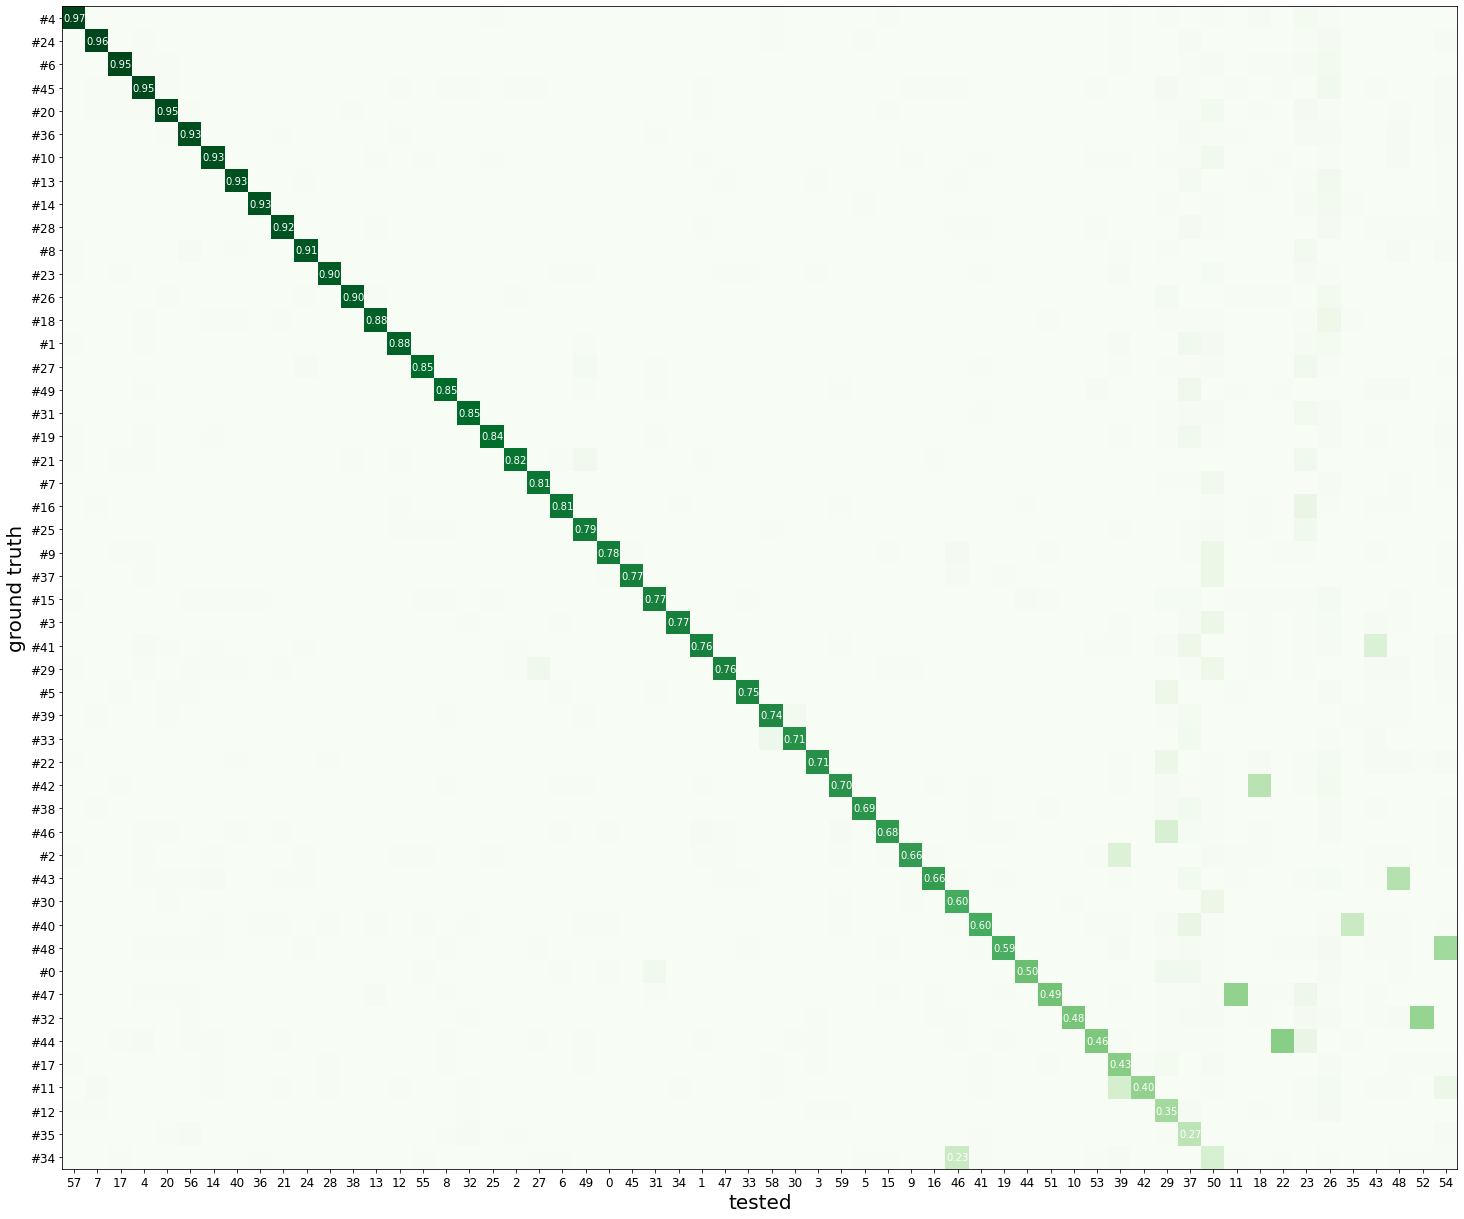

In [24]:
fig, ax = plt.subplots(figsize=(25,25))
w_agr = sw.plot_agreement_matrix(cmp, ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

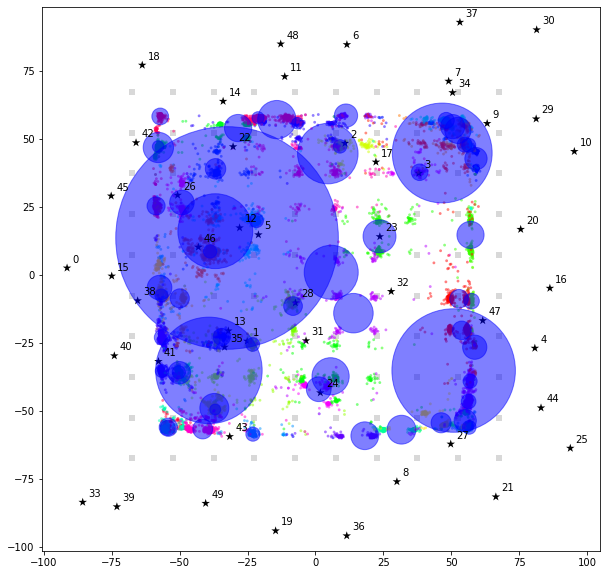

In [25]:
import matplotlib as mpl

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
for i, covar in enumerate(clustering.covariances_):
    mean = clustering.means_[i]
    if covariance_type == 'full':
        covariances = covar[:2, :2]
    elif covariance_type == 'diag':
        covariances = np.diag(covar[:2])
    elif covariance_type == 'spherical':
        covariances =  np.eye(mean.shape[0]) * covar
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, color='blue')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')
plot2DLocations(channel_positions_new, range(50), all_locations, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);



In [30]:
from sklearn.cluster import MeanShift

bandwidth_com = 10

clustering_ms= MeanShift(bandwidth=bandwidth_com).fit(cluster_data)
labels_ms =  clustering_ms.predict(cluster_data)

SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX_ms=see.NumpySortingExtractor()
SX_ms.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in spike_times_new[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels_ms):
    times_k=times[np.where(labels_ms==k)[0]]
    times_k.sort()
    SX_ms.add_unit(unit_id=k,times=times_k)

cmp_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_ms, n_jobs=1, match_score=0);
performance_measures_ms = cmp_ms.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures_ms)


Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.703625
recall                  0.758294
precision               0.875047
false_discovery_rate    0.124953
miss_rate               0.241706
dtype: float64


In [ ]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
#alpha = 8
#bandwidth_com = 5.5
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(wf_list[0][0])//2 

waveforms_list = []
for neuron in range(50):
    for waveform in wf_list[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)



if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(50):
        for i, _ in enumerate(wf_list[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(wf_list[neuron])

        
accuracy_com_GMM = []
recall_com_GMM = []
precision_com_GMM =[]

accuracy_com_MS_all = []
recall_com_MS_all = []
precision_com_MS_all = []

# Clustering with GMM
for alpha in tqdm(range(21)):
    wandb.log({"alpha": alpha})
    cluster_data = []
    labels = []
    if(pc_components !=0):
        for neuron in range(num_neurons):
            for i, com_loc in enumerate(all_locations[neuron]):
                cluster_data.append(np.concatenate((com_loc, alpha*all_neuron_pcs[neuron][i])))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)
    else:
        for neuron in range(num_neurons):
            for i, vae_loc in enumerate(all_locations[neuron]):
                cluster_data.append((com_loc[1:3]))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)

    clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
    labels =  clustering.predict(cluster_data)


    SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
    SX=see.NumpySortingExtractor()
    SX.set_sampling_frequency(32000)
    times = []
    for neuron in range(num_neurons):
        for time in spike_times_new[neuron]:
            times.append(time)
    times = np.asarray(times)
    for k in np.unique(labels):
        times_k=times[np.where(labels==k)[0]]
        times_k.sort()
        SX.add_unit(unit_id=k,times=times_k)

    cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
    performance_measures = cmp.get_performance(method='pooled_with_average')

    print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
    print(performance_measures)
    
    accuracy_com_GMM.append(performance_measures[0])
    recall_com_GMM.append(performance_measures[1])
    precision_com_GMM.append(performance_measures[2])

    wandb.log({
        "accuracy_COM_GMM": performance_measures[0],
        "recall_COM_GMM": performance_measures[1],
        "precision_COM_GMM": performance_measures[2],
        "false_discovery_rate_COM_GMM": performance_measures[3],
        "miss_rate_COM_GMM": performance_measures[4]
    })


    recgen = mr.load_recordings(recording_directory + recording_name)
    channel_positions = recgen.channel_positions

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
    for i, covar in enumerate(clustering.covariances_):
        mean = clustering.means_[i]
        if covariance_type == 'full':
            covariances = covar[:2, :2]
        elif covariance_type == 'diag':
            covariances = np.diag(covar[:2])
        elif covariance_type == 'spherical':
            covariances =  np.eye(mean.shape[0]) * covar
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],
                                  180 + angle, color='blue')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    plot2DLocations(channel_positions_new, range(50), all_locations, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);


    wandb.log({
        "Clustering GMM colorful COM": wandb.Image(plt)
    })
    
    accuracy_com_MS = []
    recall_com_MS = []
    precision_com_MS = []
    
    for bandwidth_com in range(1,21):
        wandb.log({"bandwidth_COM": bandwidth_com})
        clustering_ms= MeanShift(bandwidth=bandwidth_com).fit(cluster_data)
        labels_ms =  clustering_ms.predict(cluster_data)



        SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
        SX_ms=see.NumpySortingExtractor()
        SX_ms.set_sampling_frequency(32000)
        times = []
        for neuron in range(num_neurons):
            for time in spike_times_new[neuron]:
                times.append(time)
        times = np.asarray(times)
        for k in np.unique(labels_ms):
            times_k=times[np.where(labels_ms==k)[0]]
            times_k.sort()
            SX_ms.add_unit(unit_id=k,times=times_k)

        cmp_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_ms, n_jobs=1, match_score=0);
        performance_measures_ms = cmp_ms.get_performance(method='pooled_with_average')

        print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
        print(performance_measures_ms)

        wandb.log({
            "accuracy_COM_meanshift": performance_measures_ms[0],
            "recall_COM_meanshift": performance_measures_ms[1],
            "precision_COM_meanshift": performance_measures_ms[2],
            "false_discovery_rate_COM_meanshift": performance_measures_ms[3],
            "miss_rate_COM_meanshift": performance_measures_ms[4]
        })
        
        accuracy_com_MS.append(performance_measures_ms[0])
        recall_com_MS.append(performance_measures_ms[1])
        precision_com_MS.append(performance_measures_ms[2])
        
    
    accuracy_com_MS_all.append(accuracy_com_MS)
    recall_com_MS_all.append(recall_com_MS)
    precision_com_MS_all.append(precision_com_MS)
    

In [ ]:
plt.plot(range(0,21),accuracy_com_GMM, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_com_GMM, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_com_GMM, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Center of Mass - GMM')
plt.legend()
plt.grid()

wandb.log({
    "Alpha for GMM COM": wandb.Image(plt)
})

plt.show()

In [ ]:
acc_ms_COM = []
recall_ms_COM = []
precision_ms_COM = []
for i in range(21):
    acc_ms_COM.append(max(accuracy_com_MS_all[i])) 
    recall_ms_COM.append(max(recall_com_MS_all[i]))
    precision_ms_COM.append(max(precision_com_MS_all[i]))

In [ ]:
plt.plot(range(0,21),acc_ms_COM, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_ms_COM, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_ms_COM, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Center of Mass - Mean Shift')
plt.legend()
plt.grid()

wandb.log({
    "Alpha for Mean Shift COM": wandb.Image(plt)
})

plt.show()


# peak localization for monopolar_triangulation

In [31]:
job_kwargs = dict(chunk_duration='1s', n_jobs=-1, progress_bar=True)

peaks = st.get_peaks_from_templates(
    waveforms,
    peak_sign="both",
    radius_um=20,
    **job_kwargs,
)

compute waveform features: 100%|███████████████| 60/60 [00:00<00:00, 104.75it/s]


In [32]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

job_kwargs = dict(chunk_duration='1s', n_jobs=1, progress_bar=True)

peak_locations_mt = localize_peaks(recording_preprocessed, peaks, method= 'monopolar_triangulation',
                                ms_before=1, ms_after=1, method_kwargs={'local_radius_um': 20, 'max_distance_um': 100, 'optimizer': 'least_square'}, **job_kwargs)


wandb.log({
    "method_mt": method,
    "ms_before_mt": ms_before,
    "ms_after_mt": ms_after,
    **method_kwargs
})

localize peaks: 100%|###########################| 60/60 [01:18<00:00,  1.31s/it]


In [33]:
from collections import defaultdict


all_errors_mt = defaultdict(list)
all_locations_mt = defaultdict(list)


for i in range(len(peak_locations_mt)): #len(peak_locations)):
    
    unit_id = int(s[1][i][1:])
    neuron_pos = soma_positions[unit_id]
    est_pos_mt = peak_locations_mt[i]
    error_dist_mt = np.linalg.norm(np.array([est_pos_mt['x'], est_pos_mt['y']]) - neuron_pos[1:3])
    all_errors_mt[unit_id].append(error_dist_mt)
    all_locations_mt[unit_id].append([est_pos_mt['x'], est_pos_mt['y']])



In [34]:
neuron_error_mt = 0
neuron_std_mt = 0 
neuron_errors_all_mt = []
neuron_stds_all_mt = []
spike_errors_all_mt = []


for neuron in range(50):#good_indices:#range(50):
    if(len(all_errors_mt[neuron]) != 0):
        neuron_error_mt = np.mean(all_errors_mt[neuron])
        neuron_std_mt = np.std(all_errors_mt[neuron])
        spike_errors_all_mt = spike_errors_all_mt + all_errors_mt[neuron]
        neuron_errors_all_mt.append(neuron_error_mt)
        neuron_stds_all_mt.append(neuron_std_mt)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all_mt)) + " +- " + str(np.std(spike_errors_all_mt)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all_mt)) + " +- " + str(np.mean(neuron_stds_all_mt)))

wandb.log({
        "Total Spike 2D Error_MT": str(np.mean(spike_errors_all_mt)) + " +- " + str(np.std(spike_errors_all_mt)),
        "Total Neuron 2D Error_MT": str(np.mean(neuron_errors_all_mt)) + " +- " + str(np.mean(neuron_stds_all_mt))
})


Total Spike 2D Error: 10.356252911030412 +- 11.251930606144576
Total Neuron 2D Error: 11.653031174274005 +- 8.166821736423797


In [35]:
neu_errors_monopolar = defaultdict(list)
for unit in range(50):
    neu_errors_monopolar[unit].append(np.mean(all_errors_mt[unit]))

In [36]:
neu_errors_monopolar

defaultdict(list,
            {0: [22.70348045403095],
             1: [5.087008189505302],
             2: [4.412548248915071],
             3: [5.566126666153105],
             4: [4.4684231854974605],
             5: [2.5573656717196984],
             6: [3.1183649698934977],
             7: [11.973007096381744],
             8: [10.954945706322418],
             9: [9.969785876240032],
             10: [12.239757061138752],
             11: [16.490500347464625],
             12: [14.382541177540428],
             13: [1.7940258509542955],
             14: [6.595587337364796],
             15: [10.198099016191696],
             16: [12.903803791185648],
             17: [24.362288477609503],
             18: [5.189969549533945],
             19: [9.591639917226688],
             20: [8.257247240835145],
             21: [16.06034363548755],
             22: [14.654746631482064],
             23: [7.686575908007861],
             24: [2.50475038070706],
             25: [25.655103054

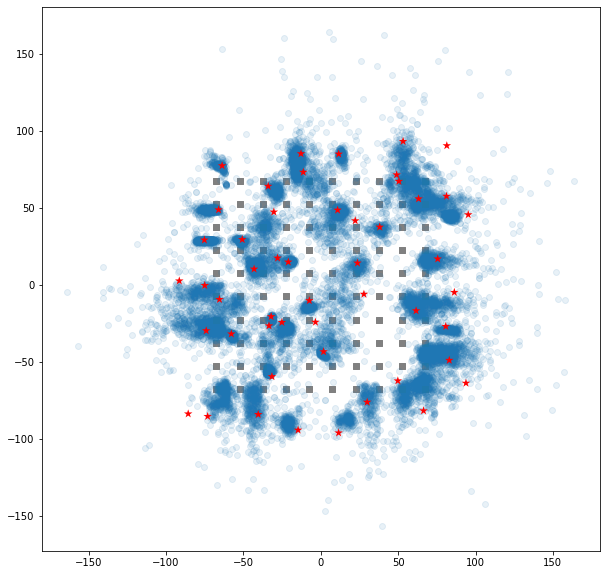

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(channel_positions_new[:,0], channel_positions_new[:,1], marker='s', color='grey')
plt.scatter(peak_locations_mt['x'], peak_locations_mt['y'], alpha=.1)
#plt.scatter(loc_y, loc_z, alpha=.1)
plt.scatter(np.array(soma_positions)[:,1], np.array(soma_positions)[:,2],  s=80, marker='*', c="red", lw=0, edgecolor='none')

wandb.log({
    "Estimated locations MT": wandb.Image(plt)
})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

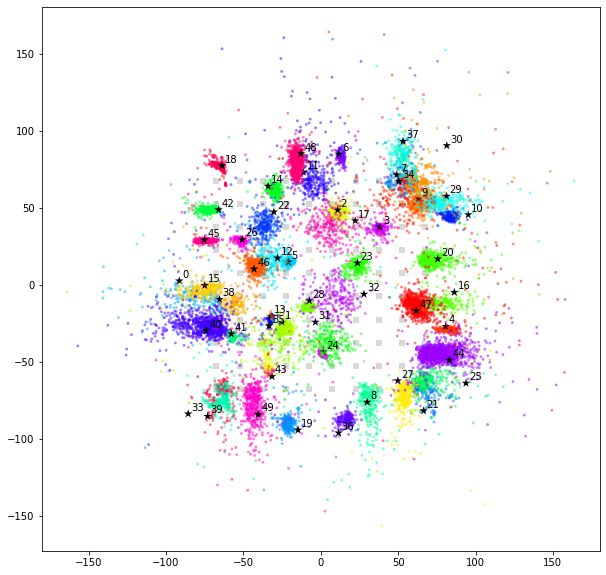

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot2DLocations(channel_positions_new, range(50), all_locations_mt, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);

wandb.log({
    "Estimated locations colorful MT": wandb.Image(plt)
})


In [39]:
spike_times_new = defaultdict(list)
wf_list = defaultdict(list)
for unit_id in tqdm(sorting.unit_ids):
    wf = waveforms.get_waveforms(unit_id)
    wf_list[int(unit_id[1:])] = wf[:,:,np.where(recording.get_channel_ids()==ext_channel[unit_id])[0][0]] 
    for spike_time in sorting.get_unit_spike_train(unit_id):
        spike_times_new[int(unit_id[1:])].append(spike_time)
        
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
alpha = 20
num_clusters =60
covariance_type = 'spherical'
middle_frame = len(wf_list[0][0])//2

waveforms_list = []
for neuron in range(50):
    for waveform in wf_list[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)


if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(50):
        for i, _ in enumerate(wf_list[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(wf_list[neuron])
        
cluster_data_mt = []
labels_mt = []
if(pc_components !=0):
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(all_locations_mt[neuron]):
            cluster_data_mt.append(np.concatenate((vae_loc, alpha*all_neuron_pcs[neuron][i])))
            labels_mt.append(neuron)
    cluster_data_mt = np.asarray(cluster_data_mt)
else:
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(all_locations_mt[neuron]):
            cluster_data_mt.append((vae_loc[1:3]))
            labels_mt.append(neuron)
    cluster_data_mt = np.asarray(cluster_data_mt)

clustering_mt = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data_mt)
labels_mt =  clustering_mt.predict(cluster_data_mt)


SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX_mt=see.NumpySortingExtractor()
SX_mt.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in spike_times_new[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels_mt):
    times_k=times[np.where(labels_mt==k)[0]]
    times_k.sort()
    SX_mt.add_unit(unit_id=k,times=times_k)

cmp_mt = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_mt, n_jobs=1, match_score=0);
performance_measures_mt = cmp_mt.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures_mt)



  0%|          | 0/50 [00:00<?, ?it/s]

Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.766565
recall                  0.806735
precision               0.910883
false_discovery_rate    0.089117
miss_rate               0.193265
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

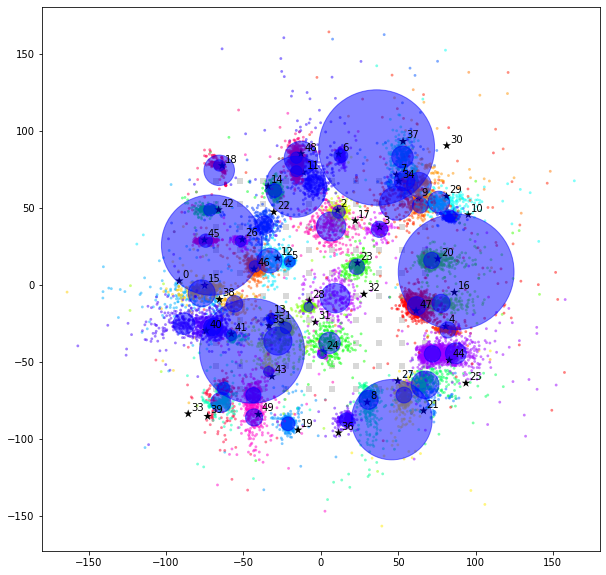

In [40]:
import matplotlib as mpl

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
for i, covar in enumerate(clustering_mt.covariances_):
    mean = clustering_mt.means_[i]
    if covariance_type == 'full':
        covariances = covar[:2, :2]
    elif covariance_type == 'diag':
        covariances = np.diag(covar[:2])
    elif covariance_type == 'spherical':
        covariances =  np.eye(mean.shape[0]) * covar
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, color='blue')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')
plot2DLocations(channel_positions_new, range(50), all_locations_mt, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);



In [41]:
from sklearn.cluster import MeanShift

bandwidth_mt = 13
clustering_mt_ms= MeanShift(bandwidth=bandwidth_mt).fit(cluster_data_mt)
labels_mt_ms =  clustering_mt_ms.predict(cluster_data_mt)

SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX_mt_ms=see.NumpySortingExtractor()
SX_mt_ms.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in spike_times_new[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels_mt_ms):
    times_k=times[np.where(labels_mt_ms==k)[0]]
    times_k.sort()
    SX_mt_ms.add_unit(unit_id=k,times=times_k)

cmp_mt_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_mt_ms, n_jobs=1, match_score=0);
performance_measures_mt_ms = cmp_mt_ms.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures_mt_ms)


Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.789849
recall                  0.833217
precision               0.923464
false_discovery_rate    0.076536
miss_rate               0.166783
dtype: float64


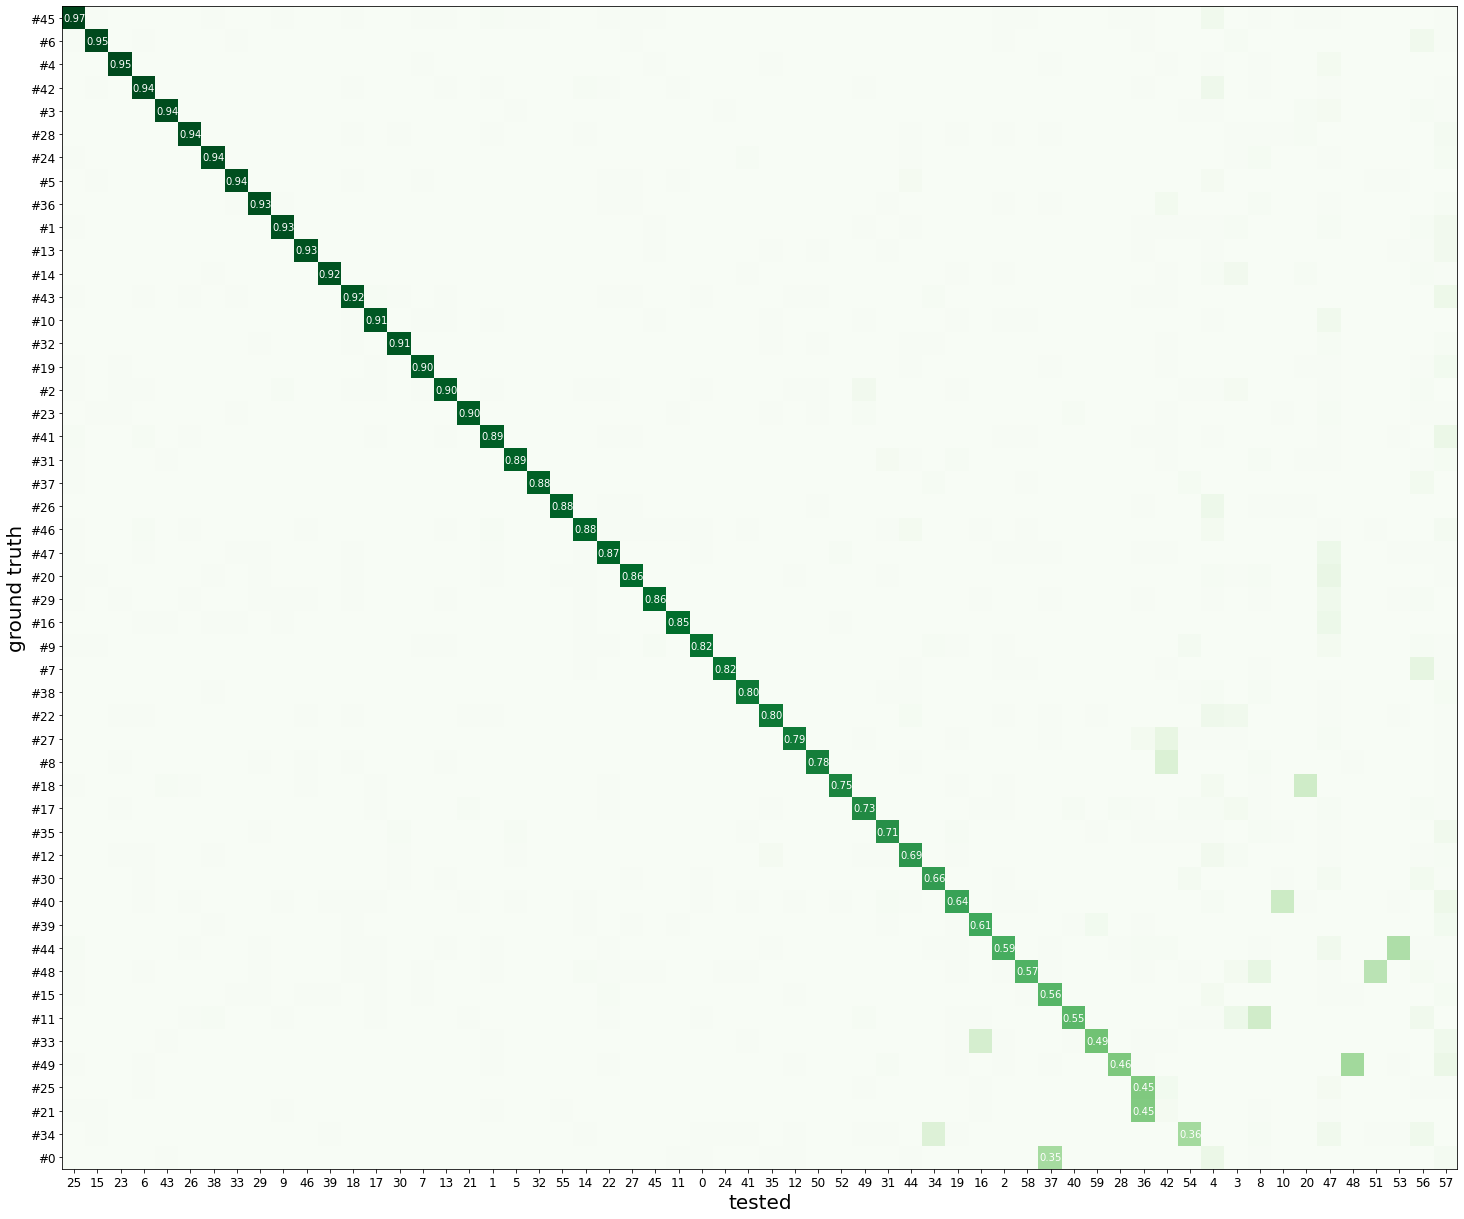

In [42]:
fig, ax = plt.subplots(figsize=(25,25))
w_agr = sw.plot_agreement_matrix(cmp_mt, ax=ax)

## Searching parameters

In [ ]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
#alpha = 8
#bandwidth_com = 5.5
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(wf_list[0][0])//2

waveforms_list = []
for neuron in range(50):
    for waveform in wf_list[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)


if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(50):
        for i, _ in enumerate(wf_list[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(wf_list[neuron])

        
accuracy_mt_GMM = []
recall_mt_GMM = []
precision_mt_GMM = []

accuracy_mt_MS_all = []
recall_mt_MS_all = []
precision_mt_MS_all = []

# Clustering with GMM
for alpha in tqdm(range(21)):
    wandb.log({"alpha": alpha})
    cluster_data_mt = []
    labels_mt = []
    if(pc_components !=0):
        for neuron in range(num_neurons):
            for i, mono_loc in enumerate(all_locations_mt[neuron]):
                cluster_data_mt.append(np.concatenate((mono_loc, alpha*all_neuron_pcs[neuron][i])))
                labels_mt.append(neuron)
        cluster_data_mt = np.asarray(cluster_data_mt)
    else:
        for neuron in range(num_neurons):
            for i, mono_loc in enumerate(all_locations_mt[neuron]):
                cluster_data_mt.append((mono_loc[1:3]))
                labels_mt.append(neuron)
        cluster_data_mt = np.asarray(cluster_data_mt)

    clustering_mt = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data_mt)
    labels_mt =  clustering_mt.predict(cluster_data_mt)


    SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
    SX_mt=see.NumpySortingExtractor()
    SX_mt.set_sampling_frequency(32000)
    times = []
    for neuron in range(num_neurons):
        for time in spike_times_new[neuron]:
            times.append(time)
    times = np.asarray(times)
    for k in np.unique(labels_mt):
        times_k=times[np.where(labels_mt==k)[0]]
        times_k.sort()
        SX_mt.add_unit(unit_id=k,times=times_k)

    cmp_mt = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_mt, n_jobs=1, match_score=0);
    performance_measures_mt = cmp_mt.get_performance(method='pooled_with_average')

    print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
    print(performance_measures_mt)

    accuracy_mt_GMM.append(performance_measures_mt[0])
    recall_mt_GMM.append(performance_measures_mt[1])
    precision_mt_GMM.append(performance_measures_mt[2])

    wandb.log({
        "accuracy_mt_GMM": performance_measures_mt[0],
        "recall_mt_GMM": performance_measures_mt[1],
        "precision_mt_GMM": performance_measures_mt[2],
        "false_discovery_rate_mt_GMM": performance_measures_mt[3],
        "miss_rate_mt_GMM": performance_measures_mt[4]
    })

    
    recgen = mr.load_recordings(recording_directory + recording_name)
    channel_positions = recgen.channel_positions

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
    for i, covar in enumerate(clustering_mt.covariances_):
        mean = clustering_mt.means_[i]
        if covariance_type == 'full':
            covariances = covar[:2, :2]
        elif covariance_type == 'diag':
            covariances = np.diag(covar[:2])
        elif covariance_type == 'spherical':
            covariances =  np.eye(mean.shape[0]) * covar
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],
                                  180 + angle, color='blue')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    plot2DLocations(channel_positions_new, range(50), all_locations_mt, soma_positions, dims=[0,1], dims_soma=[1,2], alpha=.5, ax=ax, annotate=True);

    wandb.log({
        "Clustering GMM colorful Monopolar Triangulation": wandb.Image(plt)
    })
    
    accuracy_mt_MS = []
    recall_mt_MS = []
    precision_mt_MS = []
    
    for bandwidth_mt in range(1,21):
        wandb.log({"bandwidth_mt": bandwidth_mt})

        clustering_mt_ms= MeanShift(bandwidth=bandwidth_mt).fit(cluster_data_mt)
        labels_mt_ms =  clustering_mt_ms.predict(cluster_data_mt)
        
        
        SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
        SX_mt_ms=see.NumpySortingExtractor()
        SX_mt_ms.set_sampling_frequency(32000)
        times = []
        for neuron in range(num_neurons):
            for time in spike_times_new[neuron]:
                times.append(time)
        times = np.asarray(times)
        for k in np.unique(labels_mt_ms):
            times_k=times[np.where(labels_mt_ms==k)[0]]
            times_k.sort()
            SX_mt_ms.add_unit(unit_id=k,times=times_k)

        cmp_mt_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_mt_ms, n_jobs=1, match_score=0);
        performance_measures_mt_ms = cmp_mt_ms.get_performance(method='pooled_with_average')

        print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
        print(performance_measures_mt_ms)

        wandb.log({
            "accuracy_mt_meanshift": performance_measures_mt_ms[0],
            "recall_mt_meanshift": performance_measures_mt_ms[1],
            "precision_mt_meanshift": performance_measures_mt_ms[2],
            "false_discovery_rate_mt_meanshift": performance_measures_mt_ms[3],
            "miss_rate_mt_meanshift": performance_measures_mt_ms[4]
        })
        
        accuracy_mt_MS.append(performance_measures_mt_ms[0])
        recall_mt_MS.append(performance_measures_mt_ms[1])
        precision_mt_MS.append(performance_measures_mt_ms[2])
        
    
    accuracy_mt_MS_all.append(accuracy_mt_MS)
    recall_mt_MS_all.append(recall_mt_MS)
    precision_mt_MS_all.append(precision_mt_MS)
    

In [ ]:
plt.plot(range(0,21),accuracy_mt_GMM, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_mt_GMM, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_mt_GMM, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Monopolar Triangulation - GMM')
plt.legend()
plt.grid()

wandb.log({
    "Alpha for GMM Monopolar": wandb.Image(plt)
})

plt.show()

In [ ]:
acc_mono_ms = []
recall_mono_ms = []
precision_mono_ms = []
for i in range(21):
    acc_mono_ms.append(max(accuracy_mt_MS_all[i]))
    recall_mono_ms.append(max(recall_mt_MS_all[i]))
    precision_mono_ms.append(max(precision_mt_MS_all[i]))

In [ ]:
accuracy_mt_MS_all[16]

In [ ]:
plt.plot(range(0,21),acc_mono_ms, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_mono_ms, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_mono_ms, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Monopolar Triangulation - Mean Shift')
plt.legend()
plt.grid()

wandb.log({
    "Alpha for MeanShift Monopolar": wandb.Image(plt)
})

plt.show()